## <font color=purple>**2023 1st WBDS LA Camp "Introduction to Bioinformatics and Data Science"** 
###**Brenda Torres Huerta** 

El **objetivo** de mi proyecto fue analizar el genoma de la bacteria gram negativa *Serratia marcescens*, un patógeno oportunista de insectos que causa bacteriemia en la hemolinfa y genera una muerte rápida. 

En este proyecto realicé:

*   Predicción de genes en un genoma bacteriano
*   Búsqueda de secuencias de proteínas de referencia relacionadas con serralisinas en la base de datos UniprotKB
*   Análisis de homología con BLASTp
*   Visualización de resultados de anotación con pyCirclize 
*   Análisis funcionales con InterPro
*   Análisis filogenéticos

Realicé una búsqueda de las secuencias de genes que codifican el **factor de virulencia llamado serralisina**, que tiene actividad insecticida al degradar los factores inmunes humorales en insectos. 

La **serralisina** es una **metaloproteasa** conservada en varias especies de bacterias, que se caracteriza por un motivo de unión al zinc (HEXXHXXGXXHZ).

### <font color=purple>**1.Preparación del entorno**


Las bibliotecas necesarias para que todo el código funcione son las siguientes:

1.   **pyCirclize** para visualizar nuestros datos genómicos
2.   **pyrodigal** para la predicción de genes codificantes
3.   **requests** para interactuar con las APIs de NCBI, UniProt e InterProScan
4.   **seaborn** para visualizar algunas de las propiedades genómicas obtenidas
5.   **subprocess** ejecutar comandos fuera del entorno de python
6.   **BioPython** para el manejo de secuencias
7.   **io** para conectar las entradas y salidas de los distintos programas
8.   **pandas** para el manejo general de datos

In [1]:
# Instalación de bibliotecas

!pip3 install matplotlib
!pip3 install pandas
!pip3 install pycirclize
!pip3 install pyrodigal
!pip3 install requests
!pip3 install seaborn
!pip3 install biopython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 KB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 10.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 37.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Importar librerías 

import matplotlib.pyplot as plt
import numpy  as np
import pandas as pd
import pyrodigal
import requests
import seaborn as sns
import subprocess
import sys
from Bio import SeqIO
from io                 import StringIO
from matplotlib.patches import Patch
from pycirclize         import Circos
from pycirclize.parser  import Gff
from requests.adapters  import HTTPAdapter, Retry

In [3]:
#Ingresar permisos para Entrez "credentials"

from Bio import Entrez
Entrez.email   = "brendth@gmail.com"
Entrez.api_key = "e8e1eabcd090b798410d159d4c6a2b6a4708"

### <font color=purple>**2.Obtención del genoma de** *Serratia mirescens*

El número de acceso del genoma completo que utilizaré en este análisis es **CP053918.1** del bioproyecto PRJNA634799.

In [4]:
# Descargar secuencia

accession = "CP053918.1"
genome = Entrez.efetch(db="nucleotide",
                       id=accession,
                       format="gb",
                       rettype="text")
record = SeqIO.read(genome, "genbank")
genome_length = len(record.seq)

In [5]:
# Datos del genoma
record

SeqRecord(seq=Seq('GTGGAGTCCGCCGTGTCACTTTCGCTTTGGCAGCAGTGTCTTGCCCGATTGCAG...CGA'), id='CP053918.1', name='CP053918', description='Serratia marcescens strain LY1 chromosome, complete genome', dbxrefs=['BioProject:PRJNA634799', 'BioSample:SAMN15009256'])

In [6]:
#Tamaño del genoma
genome_length

5171649

### <font color=purple>**3.Predicción de genes**

Usé pyrodigal para la predicción de los genes en el genoma de *Serratia*, específicamente la secuencia de codificación (CDS). Para ello utilicé el siguiente código**:**

In [7]:
orf_finder = pyrodigal.OrfFinder()
orf_finder.train(bytes(record.seq))
orf_genes = orf_finder.find_genes(bytes(record.seq))

Los resultados se almacenaron en **orf_genes**, que además contiene información sobre los resultados de la traducción de los cds, es decir, las secuencias de las proteínas, las posiciones de las regiones codificantes, el sentido de la traducción, entre otros.

Las secuencias de aminoácidos de los genes predichos los almacenaré en un nuevo archivo que nombraré como **CP053918.1.pep**, y el prefijo lo establecí como Smir

In [8]:
aa_file = accession + ".pep"
prefix  = "Smir"
with open(aa_file, "w") as orf_gene:
    orf_genes.write_translations(orf_gene,sequence_id=prefix)

In [9]:
gff_file = accession + ".gff"
prefix  = "Smir"
with open(gff_file, "w") as orf_gene:
    orf_genes.write_gff(orf_gene,sequence_id=prefix)

*   El archivo **.pep** que contiene las secuencias de aminoácidos de los genes putativos de *S. mirescens* lo ocuparé para realizar análisis funcionales y de homología contra una base de datos curada
*   Con el archivo **.gff** visualizaré los resultados de las predicciones realizadas

### <font color=purple>**4.Creación de un set de secuencias de referencia para análisis de homología**


In [12]:
#Realizar la búsqueda de genes relacionados con serralysin de datos revisados

uniprot_api_url  = "https://rest.uniprot.org/uniprotkb/stream"
uniprot_api_args = {"compressed" : "false",
                    "format"     : "fasta",
                    "query"      : "(serralysin) AND (reviewed:true)"}
uniprot_ref_seqs = requests.get(uniprot_api_url,params=uniprot_api_args).text

In [13]:
# Almacenar el archivo en formato fasta y guardarlo en el disco duro

uniprot_seqs_file = open("uniprot_sequences.fasta", "wt")
uniprot_seqs_file.write(uniprot_ref_seqs)
uniprot_seqs_file.close()

### <font color=purple>**5.Creación de una base de datos tipo BLAST**

La base de datos para los análisis de homología la realicé de manera local, para ello, instalé blast+ en linux de la siguiente forma:

**1)** Ejecuté el siguiente comando para obtener el programa **blast-2.3.0**

```
$ wget ftp://ftp.ncbi.nlm.nih.gov/blast/executables/LATEST/ncbi-blast-2.3.0+-x64-linux.tar.gz
```
**2)** Descomprimí el archivo y agregué la ruta del bin al path de linux

```
$ tar -xzvf ncbi-blast-2.3.0+-x64-linux.tar.gz
$ cd ncbi-blast-2.3.0+/bin

#Exportar y guardar la ubicación de los ejecutables al PATH
$ sudo nano .bashrc
export PATH="/home/brendth/PROGRAMAS/ncbi-blast-2.9.0+/bin:$PATH"
```
**3)** Para realizar la base de datos ocupé el archivo **uniprot_sequences.fasta** que descargué en el paso anterior y ocupé el siguiente comando:

```
$ makeblastdb -in uniprot_sequences.fasta -dbtype prot -out UniprotSequences
```
Este comando creó la base de datos tipo blast que consiste en los siguientes archivos:

1.   UniprotSequences.pdb
2.   UniprotSequences.phr
3.   UniprotSequences.pin
4.   UniprotSequences.pjs
5.   UniprotSequences.pot
6.   UniprotSequences.psq
7.   UniprotSequences.ptf
8.   UniprotSequences.pto

### <font color=purple>**6. Análisis de homología**

La base de datos de referencia contiene **88 secuencias relacionadas con el factor de virulencia serralysin** y a partir del **genoma** se obtuvieron **4,763 secuencias** no caracterizadas. 

**1)** Realicé una comparación de las secuencias del genoma con las de UniprotKB, para ello utilicé la herramienta de **blast**p de manera local con el siguiente comando:
```
$ blastp -query CP053918.1.pep -db DataBase/UniprotSequences -evalue 1e-9 -num_threads 8 -outfmt 11 -out blastp_out_file.asn
```
**2)** Para **formatear** el resultado y obtener un archivo con la información de:

*   qseqid: Seq-id del query
*   qlen: Longitud del query
*   sseqid: Seq-id del subject
*   slen: Longitud del subject
*   qstart: Inicio de la alineación del query
*   qend: Fin de la alineación del query
*   sstart: Inicio de la alineación del subject
*   send: Fin de la alineación del subject
*   evalue
*   score
*   length: Longitud de la alineación
*   pident: Porcentaje de coincidencias idénticas
*   qcovs: Cobertura del query per subject
*   positive: Número de scoring positivos

Para ello ocupé el siguiente comando:
```
$ blast_formatter -archive blastp_out_file.asn -outfmt '6 qseqid qlen sseqid slen qstart qend sstart send evalue score length pident qcovs positive' -out blastp_out_file.tsv
```

### <font color=purple>**7. Análisis de los resultado Blastp**

Los resultados del análisis blastp están en el archivo **blastp_out_file.tsv**, pero hay que agregar los nombres de las columnas. Para agregarlas, importé la tabla a un dataframe de pandas y asigné los nombres al definir la variable **blastp_out_format**. Después cargo la tabla y le agregó los nombres de las columnas.

In [14]:
blast_out_format = "6 qseqid qlen sseqid slen qstart qend sstart send evalue score length pident qcovs positive"
blast_out_format

'6 qseqid qlen sseqid slen qstart qend sstart send evalue score length pident qcovs positive'

In [18]:
blastp_column_names = blast_out_format.split(" ")[1:]
blastp_df = pd.read_csv("/content/blastp_out_file.tsv", sep="\t", names=blastp_column_names)
blastp_df.head(6)

,qseqid,qlen,sseqid,slen,qstart,qend,sstart,send,evalue,score,length,pident,qcovs,positive
0,Smir_184,488,sp|P07268|PRZN_SERME,487,1,487,1,487,0.0,2542,487,99.384,99,486
1,Smir_184,488,sp|P23694|PRZN_SERMA,487,1,487,1,487,0.0,2519,487,98.768,99,483
2,Smir_184,488,sp|P19144|PRTX_DICCH,478,14,487,15,478,0.0,1590,474,64.557,97,373
3,Smir_184,488,sp|Q07295|PRTA_DICCH,472,25,487,25,472,0.0,1510,463,63.715,95,357
4,Smir_184,488,sp|P16317|PRTC_DICCH,479,16,487,18,479,0.0,1510,472,62.076,97,366
5,Smir_184,488,sp|P16316|PRTB_DICCH,481,1,487,1,481,0.0,1396,491,58.452,99,363


Como resultado obtuve 5 genes del genoma de *Serratia marcescens* que codifican proteínas homólogas a **serralisinas** **[Smir_184, Smir_2059, Smir_2176, Smir_2296, Smir_3145]**. Estas cinco proteínas tuvieron similitudes con **27** secuencias de la base de secuencias de referencia de UniprotKB.

In [19]:
candidate_genes = blastp_df["qseqid"].unique().tolist()
candidate_genes

['Smir_184', 'Smir_2059', 'Smir_2176', 'Smir_2296', 'Smir_3145']

In [20]:
genes_refseq =blastp_df["sseqid"].unique().tolist()
len(genes_refseq)

27

### <font color=purple>**8. Visualización preliminar de los datos**

Los genes bacterianos están organizados en operones, o grupos de genes corregulados. Con la biblioteca **pyCirclize** visualicé los genes que fueron anotados en el paso anterior.

Para ello transformé la información a un formato legible para **pyCirclize**:

**1)** Transformé la información del gff en un dataframe:

In [21]:
gff_columns = ["chr","source","feature_type","start","end","score","strand","phase","info"]
gff_df = pd.read_csv("/content/CP053918.1.gff", sep="\t", comment="#", header=None, names=gff_columns)
gff_df["start"] = gff_df["start"].astype(int)
gff_df["end"]   = gff_df["end"].astype(int)

In [22]:
gff_df

,chr,source,feature_type,start,end,score,strand,phase,info
0,Smir,pyrodigal_v2.1.0,CDS,1,1407,232.8,+,0,ID=Smir_1;partial=10;start_type=Edge;rbs_motif...
1,Smir,pyrodigal_v2.1.0,CDS,1412,2512,244.8,+,0,ID=Smir_2;partial=00;start_type=ATG;rbs_motif=...
2,Smir,pyrodigal_v2.1.0,CDS,2558,3643,170.9,+,0,ID=Smir_3;partial=00;start_type=ATG;rbs_motif=...
3,Smir,pyrodigal_v2.1.0,CDS,3662,6076,568.6,+,0,ID=Smir_4;partial=00;start_type=ATG;rbs_motif=...
4,Smir,pyrodigal_v2.1.0,CDS,6203,7018,183.6,+,0,ID=Smir_5;partial=00;start_type=ATG;rbs_motif=...
...,...,...,...,...,...,...,...,...,...
4758,Smir,pyrodigal_v2.1.0,CDS,5164894,5165619,88.6,-,0,ID=Smir_4759;partial=00;start_type=ATG;rbs_mot...
4759,Smir,pyrodigal_v2.1.0,CDS,5165715,5167028,107.6,-,0,ID=Smir_4760;partial=00;start_type=ATG;rbs_mot...
4760,Smir,pyrodigal_v2.1.0,CDS,5167140,5168504,277.2,-,0,ID=Smir_4761;partial=00;start_type=ATG;rbs_mot...
4761,Smir,pyrodigal_v2.1.0,CDS,5168601,5170238,366.0,-,0,ID=Smir_4762;partial=00;start_type=ATG;rbs_mot...


**2)** Obtención de información adicional del dataframe gff_df

In [ ]:
def get_gff_info(info_str):
    out_dict = {}
    info_arr = info_str.split(";")
    for line in info_arr:
        if "=" in line:
            line_arr    = line.split("=")
            field_name  = line_arr[0]
            field_value = line_arr[1]
            out_dict[field_name] = field_value
    return out_dict

In [ ]:
gff_df["annotation"] = gff_df["info"].apply(lambda x: get_gff_info(x))
gff_df["annotation"]

0       {'ID': 'Smir_1', 'partial': '10', 'start_type'...
1       {'ID': 'Smir_2', 'partial': '00', 'start_type'...
2       {'ID': 'Smir_3', 'partial': '00', 'start_type'...
3       {'ID': 'Smir_4', 'partial': '00', 'start_type'...
4       {'ID': 'Smir_5', 'partial': '00', 'start_type'...
                              ...                        
4758    {'ID': 'Smir_4759', 'partial': '00', 'start_ty...
4759    {'ID': 'Smir_4760', 'partial': '00', 'start_ty...
4760    {'ID': 'Smir_4761', 'partial': '00', 'start_ty...
4761    {'ID': 'Smir_4762', 'partial': '00', 'start_ty...
4762    {'ID': 'Smir_4763', 'partial': '00', 'start_ty...
Name: annotation, Length: 4763, dtype: object

**3)** Filtrado de datos para incluir solamente los genes relacionados con serralisinas

In [ ]:
gff_df["candidate"] = gff_df["annotation"].apply(lambda x: "include" if x["ID"] in candidate_genes else "exclude")

**4)** El resultado lo almacenamos en un nuevo archivo gff para que pyCirclize visualice unicamente los genes de interés

In [ ]:
candidate_df = gff_df.copy()
candidate_df = candidate_df[candidate_df["candidate"]=="include"][gff_columns]
candidate_df.to_csv("/content/candidates.gff", sep="\t", header=False,index=False)

In [ ]:
candidate_df

,chr,source,feature_type,start,end,score,strand,phase,info
183,Smir,pyrodigal_v2.1.0,CDS,208566,210029,281.0,+,0,ID=Smir_184;partial=00;start_type=ATG;rbs_moti...
2058,Smir,pyrodigal_v2.1.0,CDS,2196840,2198258,290.2,+,0,ID=Smir_2059;partial=00;start_type=ATG;rbs_mot...
2175,Smir,pyrodigal_v2.1.0,CDS,2320188,2322032,417.0,-,0,ID=Smir_2176;partial=00;start_type=ATG;rbs_mot...
2295,Smir,pyrodigal_v2.1.0,CDS,2453645,2455261,385.7,+,0,ID=Smir_2296;partial=00;start_type=ATG;rbs_mot...
3144,Smir,pyrodigal_v2.1.0,CDS,3391100,3392482,176.1,+,0,ID=Smir_3145;partial=00;start_type=ATG;rbs_mot...


<font color=purple>**8.1 Visualización de los datos con pyCirclize**

Con el siguiente código construiremos distintos objetos para obtener un mapa circular que nos permitirá identificar manualmente potenciales operones en el genoma de Streptomyces sp.

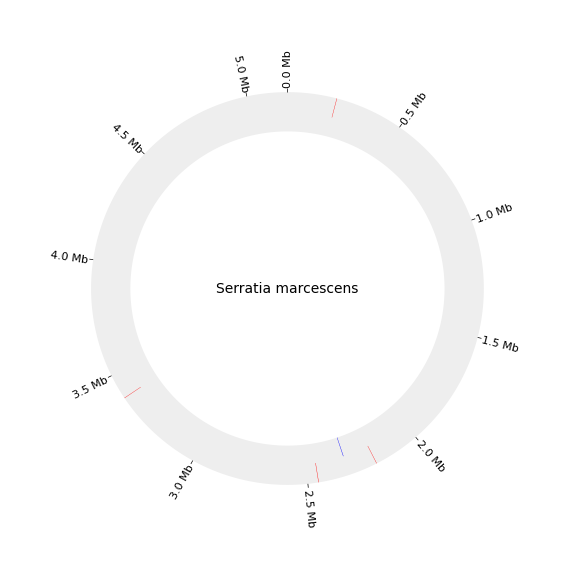

In [ ]:
circos = Circos(sectors={accession: genome_length})
circos.text("Serratia marcescens")
circos_gff = Gff(gff_file="candidates.gff")
sector = circos.get_sector(accession)
sector = circos.sectors[0]
cds_track = sector.add_track((80, 100))
cds_track.axis(fc="#EEEEEE", ec="none")
cds_track.genomic_features(circos_gff.extract_features("CDS", target_strand =  1), r_lim=(90, 100),fc="red" )
cds_track.genomic_features(circos_gff.extract_features("CDS", target_strand = -1), r_lim=(80,  90),fc="blue")
pos_list, labels = [], []
cds_track.xticks_by_interval(
    interval=500000,
    label_formatter=lambda label_value: f"{label_value/ 1000000:.1f} Mb",
    label_orientation="vertical")
fig = circos.plotfig().set_figwidth(5)

### <font color=purple>**9. Minería de proteínas homólogas a las secuencias de referencia relacionadas con serralysin**

Para obtener las secuencias de las proteínas seleccionadas y hacer futuros análisis, filtraré los operones en base a los datos del archivo de inicio, termino y sentido del gff obtenidos con pyCirclize

**1)** Para ello, obtendré primero los IDs de las cinco secuencias:

In [ ]:
operon_df = gff_df.copy()
operon_dfa = operon_df[(operon_df["start"]     >= 208566) &
                      (operon_df["end"]       <= 210029) &
                      (operon_df["strand"]    == "+")     &
                      (operon_df["candidate"] == "include")]                                     
operon_dfa.reset_index(drop=True, inplace=True)
operon_dfa

,chr,source,feature_type,start,end,score,strand,phase,info,annotation,candidate
0,Smir,pyrodigal_v2.1.0,CDS,208566,210029,281.0,+,0,ID=Smir_184;partial=00;start_type=ATG;rbs_moti...,"{'ID': 'Smir_184', 'partial': '00', 'start_typ...",include


In [ ]:
operon_dfb = operon_df[(operon_df["start"]     >= 2196840) &
                      (operon_df["end"]       <= 2198258) &
                      (operon_df["strand"]    == "+")     &
                      (operon_df["candidate"] == "include")]                                     
operon_dfb.reset_index(drop=True, inplace=True)
operon_dfb

,chr,source,feature_type,start,end,score,strand,phase,info,annotation,candidate
0,Smir,pyrodigal_v2.1.0,CDS,2196840,2198258,290.2,+,0,ID=Smir_2059;partial=00;start_type=ATG;rbs_mot...,"{'ID': 'Smir_2059', 'partial': '00', 'start_ty...",include


In [ ]:
operon_dfc = operon_df[(operon_df["start"]     >= 2320188) &
                      (operon_df["end"]       <= 2322032) &
                      (operon_df["strand"]    == "-")     &
                      (operon_df["candidate"] == "include")]                                     
operon_dfc.reset_index(drop=True, inplace=True)
operon_dfc

,chr,source,feature_type,start,end,score,strand,phase,info,annotation,candidate
0,Smir,pyrodigal_v2.1.0,CDS,2320188,2322032,417.0,-,0,ID=Smir_2176;partial=00;start_type=ATG;rbs_mot...,"{'ID': 'Smir_2176', 'partial': '00', 'start_ty...",include


In [ ]:
operon_dfd = operon_df[(operon_df["start"]     >= 2453645) &
                      (operon_df["end"]       <= 2455261) &
                      (operon_df["strand"]    == "+")     &
                      (operon_df["candidate"] == "include")]                                     
operon_dfd.reset_index(drop=True, inplace=True)
operon_dfd

,chr,source,feature_type,start,end,score,strand,phase,info,annotation,candidate
0,Smir,pyrodigal_v2.1.0,CDS,2453645,2455261,385.7,+,0,ID=Smir_2296;partial=00;start_type=ATG;rbs_mot...,"{'ID': 'Smir_2296', 'partial': '00', 'start_ty...",include


In [ ]:
operon_dfe = operon_df[(operon_df["start"]     >= 3391100) &
                      (operon_df["end"]       <= 3392482) &
                      (operon_df["strand"]    == "+")     &
                      (operon_df["candidate"] == "include")]                                     
operon_dfe.reset_index(drop=True, inplace=True)
operon_dfe

,chr,source,feature_type,start,end,score,strand,phase,info,annotation,candidate
0,Smir,pyrodigal_v2.1.0,CDS,3391100,3392482,176.1,+,0,ID=Smir_3145;partial=00;start_type=ATG;rbs_mot...,"{'ID': 'Smir_3145', 'partial': '00', 'start_ty...",include


In [ ]:
operon_gene_list = []
for index in operon_dfa.index.tolist():
    gene_id = operon_dfa["annotation"][index]["ID"]
    operon_gene_list.append(gene_id)
for index in operon_dfb.index.tolist():
    gene_id = operon_dfb["annotation"][index]["ID"]
    operon_gene_list.append(gene_id)
for index in operon_dfc.index.tolist():
    gene_id = operon_dfc["annotation"][index]["ID"]
    operon_gene_list.append(gene_id)
for index in operon_dfd.index.tolist():
    gene_id = operon_dfd["annotation"][index]["ID"]
    operon_gene_list.append(gene_id)
for index in operon_dfe.index.tolist():
    gene_id = operon_dfe["annotation"][index]["ID"]
    operon_gene_list.append(gene_id)

In [ ]:
operon_gene_list

['Smir_184', 'Smir_2059', 'Smir_2176', 'Smir_2296', 'Smir_3145']

**2)** A partir de la lista que generé con los ids de las secuencias, construí un string con las secuencias de aminoácidos de interés en formato fasta. El cuál ocuparé para análisis funcionales con la plataforma **InterPro**.

In [ ]:
query_str = ""

In [ ]:
for record in SeqIO.parse(aa_file, "fasta"):
    seq_id  = record.id
    if(seq_id in operon_gene_list):
        seq_str = str(record.seq)
        query_str+=">"+seq_id+"\n"+seq_str+"\n"
query_str = query_str.replace("*","")

In [ ]:
query_str

'>Smir_184\nMQSTKKAIEITESSLAAATTGYDAVDDLLHYHERGNGIQINGKDSFSNEQAGLFITRENQTWNGYKVFGQPIKLTFSFPDYKFSSTNVAGDTGLSKFSAEQQQQAKLSLQSWADVANITFTEVAAGQKANITFGNYSQDRPGHYDYGTQAYAFLPNTIWQGQDLGGQTWYNVNQSNVKHPATEDYGRQTFTHEIGHALGLSHPGDYNAGEGNPTYRDVTYAEDTRQFSLMSYWSETNTGGDNGGHYAAAPLLDDIAAIQHLYGANLSTRTGDTVYGFNSNTGRDFLSTTSNSQKVIFAAWDAGGNDTFDFSGYTANQRINLNEKSFSDVGGLKGNVSIAAGVTIENAIGGSGNDVIVGNAANNVLKGGAGNDVLFGGGGADELWGGAGKDIFVFSAASDSAPGASDWIRDFQKGIDKIDLSFFNKEAQSSDFIHFVDHFSGAAGEALLSYNASNNVTDLSVNIGGHQAPDFLVKIVGQVDVATDFIV\n>Smir_2059\nMSSSNASVKAEGVLALLGAYKPDEDDTITVLHPSKTFENAGLELVRGDRSWHDKGVTDTPVSLTYSFWEKAPGNMSSMGISGFSSFNAEQREQAKLSLQSWSDVANITFTETSNTAAANIKFGLFDYSSRGSYAFAYNPDSSPSVAGQTWYNAKNHTFVNNQIHENEYGRQTFTHEIGHALGLQHPGDYNAAPGVSITYGKDATYFEDSRAHSLMSYFSESNTGQDFKGAYSSGPLLNDITAIQHFYGANMNTRTGDTVYGFNSNTDRDFLTATGAQDKIIFTAWDAGGNDTFDFSGFGQNQRINLNEKAFSDVGGLKGNVSIAAGVTIENAIGGSGNDVLVGNAADNVLKGGAGDDVLYGGKGADQLWGGAGKDTFVYFAADESTAAAPDWIRDFVRGEDKIDLTLFNTGSADGIRFVDQFSGKAGEAKLSYDEQNHVSDVAINLGGAFDGNDFLVKVVGQPLDAGDFVLA\n>Smir_2176\nM

### <font color=purple>**10. Análisis funcionales**

**InterPro** proporciona análisis funcional de proteínas clasificándolas en **familias y prediciendo dominios y sitios importantes**. Para ello, esta plataforma utiliza modelos predictivos, conocidos como firmas, proporcionados por varias bases de datos diferentes que componen el consorcio InterPro. 

El proceso de búsqueda de dominios lo dividiremos en **tres etapas**:

1.   Envío de las secuencias
2.   Consulta del status del envío
3.   Descarga de resultados

In [ ]:
#Envío de las secuencias
submit_url   = "https://www.ebi.ac.uk/Tools/services/rest/iprscan5/run"

In [ ]:
#Consulta del status del envío
progress_url = "https://www.ebi.ac.uk/Tools/services/rest/iprscan5/status"

In [ ]:
# Descarga de resultados
results_url  = "https://www.ebi.ac.uk/Tools/services/rest/iprscan5/result"

> Cada etapa acepta headers específicos

In [ ]:
submit_headers   = {"Accept":"text/plain"}
progress_headers = {"Accept":"text/plain"}
results_headers  = {"Accept":"text/tab-separated-values"}

<font color=purple>**10.1 Envío de las secuencias**

En esta etapa se debe construír un diccionario de python en donde se incorporan los requerimientos para buscar los dominios funcionales**:**

In [ ]:
submit_data = {"email":"vflorelo@gmail.com",
               "title":"operon_335_345",
               "goterms":"true",
               "pathways":"false",
               "stype":"p",
               "sequence":query_str}

> Con los datos listos, realicé el envío de mis secuencias

In [ ]:
submit_request = requests.post(submit_url,data=submit_data,headers=submit_headers)

> Con el siguiente código obtuve el **job_id** como el código de estado

In [ ]:
submit_status_code = submit_request.status_code
submit_job_id      = submit_request.text

In [ ]:
print(submit_status_code)
print(submit_job_id)

200
iprscan5-R20230317-053440-0884-77661462-p1m


<font color=purple>**10.2 Consulta del status del envío**

Con el job_id consulté el progreso del análisis con las siguientes líneas de código**:**

In [ ]:
progress_request     = requests.get(progress_url+"/"+submit_job_id,headers=progress_headers)
progress_status_code = progress_request.status_code
progress_status      = progress_request.text
print(progress_status_code)
print(progress_status)

200
FINISHED


<font color=purple>**10.3 Obtención de los resultados**

Cuando el estado del análisis fue "FINISHED", consulté los resultados del análisis, y accedí al reporte que después se formateó a un tsv para visualizar el reporte en forma tabular**:** 

In [ ]:
results_log_request = requests.get(results_url+"/"+submit_job_id+"/log",headers=results_headers)
results_tsv_request = requests.get(results_url+"/"+submit_job_id+"/tsv",headers=results_headers)

In [ ]:
print(results_log_request.text)

17/03/2023 05:28:15:219 Welcome to InterProScan-5.61-93.0
17/03/2023 05:28:15:221 Running InterProScan v5 in STANDALONE mode... on Linux
17/03/2023 05:28:22:833 RunID: hh-wp-02-10.ebi.ac.uk_20230317_052822481_sla
17/03/2023 05:28:35:873 Loading file /nfs/public/rw/es/projects/wp-jdispatcher/logs/prod/sources/jobs/iprscan5/rest/20230317/0534/iprscan5-R20230317-053440-0884-77661462-p1m.sequence
17/03/2023 05:28:35:875 Running the following analyses:
[AntiFam-7.0,CDD-3.20,Coils-2.2.1,FunFam-4.3.0,Gene3D-4.3.0,Hamap-2021_04,MobiDBLite-2.0,PANTHER-17.0,Pfam-35.0,Phobius-1.01,PIRSF-3.10,PIRSR-2021_05,PRINTS-42.0,ProSitePatterns-2022_05,ProSiteProfiles-2022_05,SFLD-4,SignalP_EUK-4.1,SignalP_GRAM_NEGATIVE-4.1,SignalP_GRAM_POSITIVE-4.1,SMART-9.0,SUPERFAMILY-1.75,TIGRFAM-15.0,TMHMM-2.0c]
Available matches will be retrieved from the pre-calculated match lookup service.

Matches for any sequences that are not represented in the lookup service will be calculated locally.
17/03/2023 05:28:37:980 27%

**Finalmente**, utilicé la biblioteca StringIO para transformar los resultados en un nuevo dataframe y examiné los resultados

In [ ]:
results_tsv_str = StringIO(results_tsv_request.text)
results_column_names = ["sequence","md5","length","database","accession","description","start","end","evalue","post_processed","date","entry","name"]
results_df = pd.read_csv(results_tsv_str,sep="\t",names=results_column_names)
results_df.to_csv("InterPro_SmarSerralysin.tsv", sep="\t")

In [ ]:
results_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 71 entries, Smir_184 to Smir_3145
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   sequence        71 non-null     object
 1   md5             71 non-null     int64 
 2   length          71 non-null     object
 3   database        71 non-null     object
 4   accession       71 non-null     object
 5   description     71 non-null     int64 
 6   start           71 non-null     int64 
 7   end             71 non-null     object
 8   evalue          71 non-null     object
 9   post_processed  71 non-null     object
 10  date            71 non-null     object
 11  entry           71 non-null     object
 12  name            45 non-null     object
dtypes: int64(3), object(10)
memory usage: 7.8+ KB


### <font color=purple>**11. Análisis filogenéticos**

<font color=purple>**11.1 Alineamiento múltiple**

Para realizar la filogenia, previamente descargué **16 secuencias** de la base de datos de referencia de serralisina (UniprotKB) que fueron homólogas con las cinco proteínas putativas de *Serratia marcescens*. Utilicé este **set de datos de 21 secuencias de proteínas**, para realizar un **alineamiento multiple con** [MAFFT](https://mafft.cbrc.jp/alignment/server/), alineamiento que edité y visualicé en [Aliview](https://ormbunkar.se/aliview/).  

Nota: El archivo que corresponde con el alineamiento múltiple está en la carpeta de Filogenia:**texto en negrita** **MAFFT-SerralysinFilogenia.fasta**



<font color=purple>**11.2 Prueba del modelo evolutivo**


Usé el alineamiento final, recortado y filtrado, para inferir las relaciones filogenéticas de las secuencias. Pero primero realicé la prueba de modelo evolutivo.

Para obtener el modelo evolutivo más adecuado para mi multialineamiento utilicé el programa [ModelTest-NG](https://github.com/ddarriba/modeltest) de la siguiente manera:
```
$ modeltest-ng -i MAFFT-SerralysinFilogenia.fasta -d aa -o ModelTest/Serralysins
```
<font color=red>**RESULTADO**

Este programa arroja cuatro salidas que se encuentran en **ModelTest_Serralysins.out**:

*   Serralysins.ckp
*   Serralysins.log
*   Serralysins.out
*   Serralysins.tree

**El mejor modelo seleccionado por los criterios de BIC, AIC y AICc fue el: WAG+G4+I**

```
                         Model         Score        Weight
----------------------------------------------------------
       BIC          WAG+I+G4+F    25832.7485        0.7310
       AIC          WAG+I+G4+F    25566.1961        0.9616
      AICc          WAG+I+G4+F    25578.1961        0.9616
```


<font color=purple>**11.3 Análisis filogenético Bayesiano**

Para realizar el análisis filogenético utilicé el software [beast2](http://www.beast2.org/) para Linux. Este programa se divide en modulos. En general los pasos que realicé para hacer la filogenía fueron los siguientes:

1.   Crear un archivo XML en el modulo **BEAUti** que contiene el alineamiento, la especificación del modelo, valores iniciales y restricciones de parámetros, configuraciones del algoritmo MCMC y las Opciones de salida. **BeautiSerralysins.xml**

2.   Ejecutamos el archivo **BeautiSerralysins.xml** con el modulo **beast**, que generará varios archivos, entre ellos se encuentra **SerralysinFilogenia.log**, con el que podemos evaluar los resultados del análisis en el programa Tracer, verificar que convergan las distribuciones posteriores y alcancen la estacionalidad.

3.   Resuimir los árboles, para ello se utiliza el archivo **SerralysinFilogenia.trees**, que contiene todos los arboles generados. Con el módulo **Treeannotator**, que toma el conjunto de árboles y encuentra el mejor soportado,
luego anota el árbol más representativo y calcula la probabilidad posterior de cada nodo y genera el archivo **Best-SerralysinFilogenia.trees**.


<font color=purple>**11.4 Edición del árbol filogenético**

Finalmente, visualicé y edité el mejor árbol filogenético en [iTOL](https://itol.embl.de/login.cgi). Archivo **Best**.


#<font color=purple>**RESUMEN DEL PROYECTO**

El genoma que bacteriano que analicé es de la especie *Serratia marcescens*, su número de acceso es **CP053918.1**. Este genoma tiene un tamaño de 5171649 bp y fue registrado por la Universidad Nomal de Leshan.


<font color=red>**Predicción de genes**

Con la búsqueda de marcos de lectura (ORFs) en pyrodigal, obtuve las predicciones de genes que codifican proteínas en formato **gff** y un archivo **fasta** con 4,763 secuencias de proteínas.

<font color=red>**Análisis de homología**

Para los análisis de homología con Blastp, consturí un base de datos de referenia a partir de las secuencias relacionadas con serralysin de UniProtKB/Swiss-Prot (revisado), que contiene secuencias no redundantes y anotadas manualmente con alta calidad. 

Esta base de datos constó de 88 secuencias, de las cuáles 27 tuvieron similitudes con 5 secuencias de proteínas de *Serratia marcescens* **CP053918.1**, con similitudes de 50 al 99%.

<font color=red>**Análisis funcionales**

Todas las proteínas fueron **anotadas funcionalmente mediante la búsqueda de dominio**s dentro de:

*   **Serralysin-like metalloprotease, C-terminal (IPR011049):** Este dominio contiene la repetición de unión a calcio de tipo hemolisina.
*   **Peptidase M10 serralysin C terminal (PF08548):** Este dominio contiene el dominio de unión a iones de calcio.
*   **Peptidase M10, metallopeptidase (IPR001818):** dominio de metaloproteasas extracelulares que degradan la matriz extracelular, se conocen como matrixinas. Son proteasas activadas por calcio, dependientes de zinc, sintetizadas como precursores inactivos (zimógenos), que se escinden proteolíticamente para producir la enzima activa.

Con los siguientes **términos GO:**

**Biological Process**
```
proteolysis (GO:0006508)
```
**Molecular Function**
```
calcium ion binding (GO:0005509)
zinc ion binding (GO:0008270)
metalloendopeptidase activity (GO:0004222)
```
**Cellular Component**
```
extracellular space (GO:0005615)
extracellular matrix (GO:0031012)
```

<font color=red>**Análisis filogenéticos**

Las cinco proteínas de serralisinas putativas se agruparon en diferentes subclados con sus homólogos más cercanos y probabilidades posteriores bayesianas (BPP) del 100 %. Solo Smir_184 se agrupó dentro del mismo clado con serralisinas de *S. marcescens* de la base de referencia Uniprotkb. Las demás estuvieron relacionadas con proteínas de otros géneros de bacterias, lo que sugiere expansiones específicas. 

Anteriormente, se habían reportado homólogos de serralisinas metaloproteasa de *Proteus mirabilis* y *Photorhabdus luminescens*, cuya función es degradar factores inmunitarios humorales como inmunoglobulina y péptidos antimicrobianos (Nielsen-LeRoux *et al*., 2012). 



Los **RESULTADOS** de este proyecto, son interesantes, el agrupamiento de las serralisinas del genoma de *S. marcescens* con otras proteínas ortólogas de bacterias de géneros diferentes es algo que podría estudiarse de manera mas exhaustiva. En este caso, solo analicé las secuencias revisadas, que solo contienen dos proteínas caracterizada para esta especie, sin embargo, puede ser que existan más proteínas dentro de esta familia de metaloproteasas, ya que todas tienen las caracteríticas de dominios y firmas para clasificarlas dentro de las serralisinas.